In [1]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img

2024-08-29 13:00:26.376741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 13:00:26.386057: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 13:00:26.468164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 13:00:26.541169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 13:00:26.600070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
#paths to files
image_dir = "../raw_data/facial_segmentation/image/"
mask_dir = "../raw_data/facial_segmentation/masks/seg/"

#variables that hold file names
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

#sorting file names
image_filenames.sort()
mask_filenames.sort()

In [3]:
size_of_file = 10000
# training on size of file number of images training
image_filenames = image_filenames[:size_of_file]
mask_filenames = mask_filenames[:size_of_file]

IMG_SIZE = (256, 256)

images = []
masks = []

In [4]:
# Load and resize the selected images and masks
for image_filename, mask_filename in zip(image_filenames, mask_filenames):
    # Load and preprocess the face image
    img = load_img(os.path.join(image_dir, image_filename), target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    # Load and preprocess the mask
    mask = load_img(os.path.join(mask_dir, mask_filename), target_size=IMG_SIZE, color_mode="grayscale")

    # mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    images.append(img)
    masks.append(mask)
# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

: 

In [5]:
# Split into training and validation sets (80% training, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
# Print shapes to confirm the split
print(f"Training data shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test masks shape: {y_test.shape}")

In [ ]:
type(y_train)
y_train.shape

(800, 256, 256)

In [ ]:
# Define valid values to keep
valid_values = {1, 2, 3, 4, 5, 7, 9, 10}


y_train_adjusted = np.where(np.isin(y_train, list(valid_values)), y_train, 0)


# Model Architecture

y_train.shape

In [ ]:
np.unique(y_train_adjusted[0])

array([ 0,  1,  2,  3,  4,  5,  7,  9, 10], dtype=uint8)

In [ ]:
label_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: 6, 9: 7, 10: 8}

# Apply the mapping
for old_value, new_value in label_mapping.items():
    y_train_adjusted[y_train == old_value] = new_value

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_sequential(input_shape, num_classes):
    model = tf.keras.Sequential()

    # Encoder Path
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # # Block 2
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))

    # # Block 3
    # model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))

    # Bottleneck
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))

    # Decoder Path (simplified version)
    # # Block 1
    # model.add(layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))

    # # Block 2
    # model.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

    # Block 3
    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

    # Output Layer
    model.add(layers.Conv2D(num_classes, (1, 1), activation='softmax'))  # 'num_classes' filters for multi-class segmentation

    return model

# Example usage
input_shape = (256, 256, 3)
num_classes = 9  # For pixel values 0 to 5
model = unet_sequential(input_shape, num_classes)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 30)   │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 512)  │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 30)   │        17,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 9)    │           279 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,069 (10.91 MB)

 Trainable params: 2,859,069 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Compilation
# Classification with more classes
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Early stopping
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

### Fiting the model
model.fit(X_train[0:50], y_train_adjusted[0:50], batch_size=16, epochs=5, validation_split=0.3, callbacks=[es], verbose=2)

Epoch 1/5
3/3 - 17s - 6s/step - accuracy: 0.3953 - loss: 2.1550 - val_accuracy: 0.8356 - val_loss: 1.5007
Epoch 2/5
3/3 - 16s - 5s/step - accuracy: 0.8751 - loss: 1.1779 - val_accuracy: 0.8370 - val_loss: 1.2701
Epoch 3/5
3/3 - 16s - 5s/step - accuracy: 0.8759 - loss: 0.9092 - val_accuracy: 0.8333 - val_loss: 0.9070
Epoch 4/5
3/3 - 16s - 5s/step - accuracy: 0.8741 - loss: 0.7663 - val_accuracy: 0.8370 - val_loss: 0.7661
Epoch 5/5
3/3 - 17s - 6s/step - accuracy: 0.8759 - loss: 0.6473 - val_accuracy: 0.8370 - val_loss: 0.7556


In [ ]:
predicted_mask = model.predict(np.expand_dims(X_train[0], axis=0))
predicted_mask = np.squeeze(predicted_mask, axis =0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


TypeError: Invalid shape (256, 256, 9) for image data

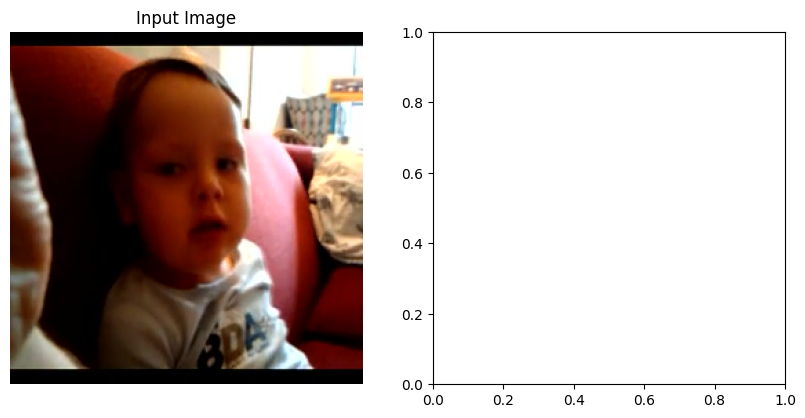

In [ ]:
import matplotlib.pyplot as plt

# Plot the input image and predicted mask
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title('Input Image')
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()


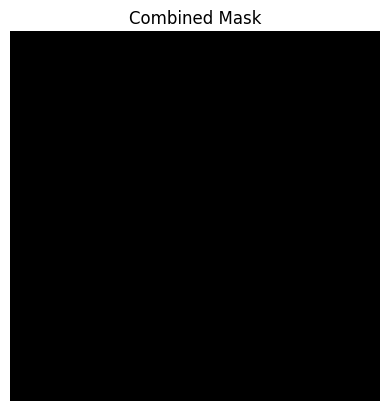

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class with the highest score for each pixel
combined_mask = np.argmax(predicted_mask, axis=-1)

# Visualize the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Mask')
plt.axis('off')
plt.show()


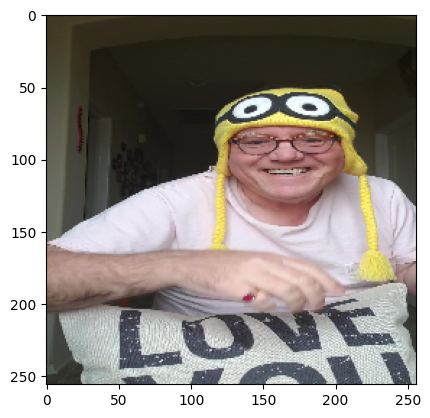

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train="/root/code/JplepeckiBR/PCA/raw_data/facial_segmentation/masks/seg/0001_0001.png"
set(np.array(y_train[100]).flatten())

IndexError: string index out of range

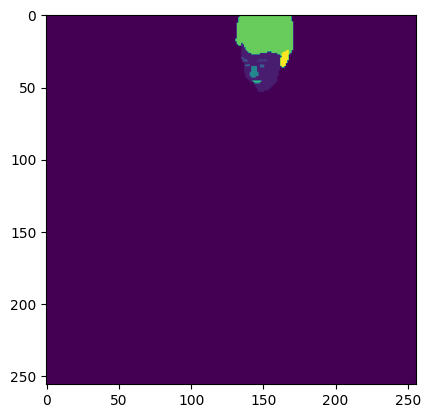

In [ ]:

plt.imshow(y_train[100])

TypeError: Invalid shape (256, 256, 9) for image data

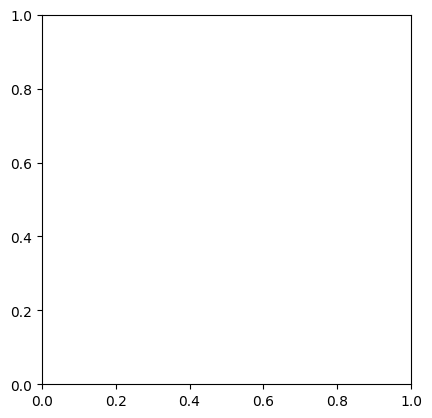

In [ ]:
plt.imshow(history[0])